<h1 align="center">Fold modelling - Fourier Series optimisation tutorial</h1>


Fourier Series optimisation is part of `LoopStructural`'s workflow; however, it performs only unconstrained optimisations. Meaning that only orientation data is used to model the observed fold geometry. In poorly outcropping regions, orientation data may not be sufficient to recover the observed fold geometry. So, in this tutorial, we will see how we can add geological knowledge to the Fourier Series optimisation process.  

This tutorial will demonstrate the use of the `FourierSerieOptimiser` class, part of the FoldModellingPlugin that can be integrated into `LoopStructural`  [(Grose et al., 2021)](https://gmd.copernicus.org/articles/14/3915/2021/). This tutorial assumes you are familiar with the concepts of fold frame and fold rotation angles [(Laurent et al., 2016)](https://linkinghub.elsevier.com/retrieve/pii/S0012821X16305209) and the S-Plot  [(Grose et al., 2017)](https://linkinghub.elsevier.com/retrieve/pii/S0191814117301864) as well as the basic use of LoopStructural for fold modelling. In case you are not familiar with these concepts, it is recommended to do the following tutorials before moving forward with this tutorial: [LoopStructural fold modelling Examples](https://github.com/Loop3D/LoopStructural/tree/master/examples/2_fold).
 

In [4]:
# from FoldModellingPlugin.FoldModellingPlugin.ipywidgets_interface import create_value_widgets, on_add_button_click, on_constraint_change, on_sub_constraint_change, display_dict_selection
from FoldModellingPlugin.FoldModellingPlugin.optimisers import FourierSeriesOptimiser as FSO
from FoldModellingPlugin.FoldModellingPlugin.helper.utils import create_fold_frame_dataset, clean_knowledge_dict
from LoopStructural import GeologicalModel
from LoopStructural.modelling.features.fold import FoldEvent
# from LoopStructural.visualisation import LavaVuModelViewer
# from custom_model_visualisation import LavaVuModelViewer
from LoopStructural.visualisation import MapView
from LoopStructural.visualisation import RotationAnglePlotter
from LoopStructural.modelling.features.fold import FoldRotationAngle, SVariogram
from LoopStructural.modelling.features import StructuralFrame, GeologicalFeature
from LoopStructural.modelling.features.fold import fourier_series
from LoopStructural.utils.helper import create_surface, create_box, get_data_bounding_box, normal_vector_to_strike_and_dip, plunge_and_plunge_dir_to_vector
import os
import time
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import IntProgress, interact, interactive

ERROR: 2023-10-17 11:15:21,377: __init__.py:21 -- Cannot use sphinx scraper, pip install -r docs/requirements.txt
ERROR: 2023-10-17 11:15:21,379: __init__.py:25 -- Missing lavavu, can't import LavaVuModelViewer


# I. Creation of a synthetic model

First, we will create a synthetic model to produce an S-Plot that we will use in the optimisation process. The synthetic model is the reference from within which we will sample data points that will be used to optimise a Fourier Series. 

###### **1. Define model bounding box**

In [5]:
# define the maximum value of xyz model box boundaries
xmin, ymin, zmin = 0, 0, 0
xmax, ymax, zmax = 1000, 1000, 1000

bounding_box = np.array([[xmin, ymin, zmin],
               [xmax, ymax, zmax]])

###### **2. Initialise a geological model**  
We will use the **`GeologicalModel`** class from `LoopStructural` to create a model object. 

In [6]:
# initiliase geological model by initialising GeologicalModel class
model = GeologicalModel(bounding_box[0, :], 
                        bounding_box[1, :])

###### **3. Build a fold frame**  
First, we will create a dataset using the `create_fold_frame_dataset()` function that returns a dataframe. The function takes the following arguments:

- **`model`**: a `GeologicalModel` object previously initialised 
- **`strike`**: the strike of the fold axial surface 
- **`dip`**: the dip of the fold axial surface

Once the dataset is created and added to `model`, a fold frame will be built.  


In [7]:
# Create a dataset for s1 to build a fold frame 
dataset, xyz = create_fold_frame_dataset(model, strike=0, dip=90)
# Add data to the initiliased GeologicalModel
model.data = dataset

In [8]:
# build the s1 fold frame
s1 = model.create_and_add_fold_frame('s1',
                                          buffer=0.3,
                                          solver='pyamg',
                                          nelements=2e4,
                                        damp=True)
model.update()

ERROR: 2023-10-17 11:15:59,869: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-10-17 11:15:59,871: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-10-17 11:15:59,872: _base_geological_feature.py:73 -- Model not set


Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-17 11:16:20,980: _geological_feature_builder.py:213 -- Not enough constraints for scalar field add more


###### **3.1. Display the fold frame**

In [8]:
# 3D displaying the s1 fold frame
viewer = LavaVuModelViewer(model, background='white')
viewer.add_isosurface(s1[0], colour='red')
viewer.add_isosurface(s1[1], colour='blue')
viewer.add_data(s1[0], disks=False, vectors=True, colour='red')
viewer.add_data(s1[1], disks=False, vectors=True, colour='blue')
# t = viewer.add_scalar_field(s1[0], cmap='prism')
# viewer.lv.colourbar(t, align=("bottom"))
viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
viewer.display()
viewer.interactive()

###### **4. Define the fold limb rotation angle profile**

In [14]:
#Define functions to create an S-Plot
def fold_limb_rotation_profile(c0, c1, c2, wl):

    theta = [c0, c1, c2, wl]
    x = np.linspace(s1[0].min(), s1[0].max(), 2000)
    flr = np.rad2deg(np.arctan(fourier_series(x, *theta)))
    # fold_limb_rotation = FoldRotationAngle(flr, x) 
    # fold_limb_rotation.fitted_params = theta
    # fold_limb_rotation.set_function(lambda x: np.rad2deg(
    #                 np.arctan(fourier_series(x, *theta))))
    plt.ylim(-90, 90)
    plt.xlabel('Fold Axial Surface Field (m)')
    plt.ylabel('Fold Limb Rotation Angle')
    plt.title('Fold Limb S-Plot')
    plt.plot(x, flr)
    plt.show()
    
    return flr, x

def define_fold_axis_orientation(plunge_direction, plunge): 
    
    fold_axis = plunge_and_plunge_dir_to_vector(plunge, plunge_direction)
    
    return fold_axis

Now, we will create a synthetic fold limb rotation angle model using Fourier Series. We will do so by using the function `fold_limb_rotation_profile`. The function takes the following arguments: 
- **`c0, c1 and c2`**: Fourier Series coefficients
- **`wl`**: the wavelength

In the following, we define a close symmetric fold.  

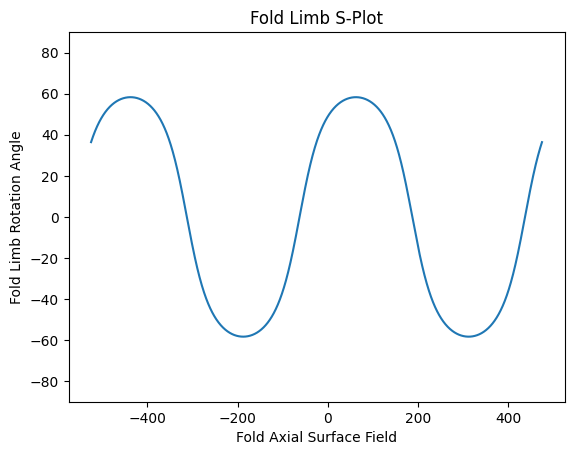

In [11]:
# assign values to the Fourier parameters
c0 = 0
c1, c2 = 2e-2, 2e-2
wl = 500
theta = [c0, c1, c2, wl]
fold_limb_rotation, x = fold_limb_rotation_profile(*theta)

# II. Fourier series optimisation

###### **1. Random sampling of the fold limb rotation curve**

Here, we will randomly sample the fold limb rotation angle curve and use the sample points as data points for the Fourier Series optimisation.  
Sampling the curve can be done by interactively changing the value of the sample size in the slider below. 

In [13]:
def sample_randomly(fold_frame_coordinate, fold_limb_rotation, sample_size, seed=180):
    np.random.seed(seed)
    n = np.arange(len(fold_frame_coordinate))
    sample_size = sample_size
    indices = np.random.choice(n, sample_size, replace=False)
    flr = fold_limb_rotation[indices]
    fld = fold_frame_coordinate[indices]
    return fld, flr
    
def update(sample_size):
    global fld, flr
    fld, flr = sample_randomly(x, fold_limb_rotation, sample_size)
    plt.ylim(-90, 90)
    plt.xlabel('Fold Axial Surface Field (m)')
    plt.ylabel('Fold Limb Rotation Angle')
    plt.title('Fold Limb S-Plot')
    plt.plot(x, fold_limb_rotation, color='black', label='Reference model')
    plt.scatter(fld, flr, color='blue', label='Random data points')
    plt.legend()
    plt.show()
    # return fld, flr

# Create a slider for sample_size
sample_size_slider = widgets.IntSlider(
    value=6,
    min=1,
    max=100,
    step=1,
    description='Sample Size:',
    continuous_update=True
)

# Use interact to create the interactive widget
interactive_sampling = interactive(update, sample_size=sample_size_slider)
display(interactive_sampling)
# fld, flr = interactive_sampling.result

interactive(children=(IntSlider(value=6, description='Sample Size:', min=1), Output()), _dom_classes=('widget-…

###### **2. Input geological knowledge**  

Now, we can add geological knowledge to the optimisation process. Here, "geological knowledge" refers to the indirect observations made by geologists in the field, such as the tightness, asymmetry, and axial traces. 

The geological knowledge is added to the optimisation as a Python dictionary called `geological_knowledge`. The `geological_knowledge` dictionary contains three sub-dictionaries: 
- **`'fold_limb_rotation_angle': {}`**
- **`'fold_axis_rotation_angle': {}`**
- **`'fold_axial_surface': {}`**

Note that using geological knowledge in the optimisation is optional; however, it will be critical if the dataset cannot constrain the observed folds.

These can be filled interactively by running the following cell.

In [19]:
# Run cell to fill geological knowledge dictionary
# Initial dictionary structure
geological_knowledge = {
    'fold_limb_rotation_angle': {},
    'fold_axis_rotation_angle': {},
    'fold_axial_surface': {}
}

# Mapping of Major Constraints to their sub-constraints
sub_constraints = {
    'fold_limb_rotation_angle': ['tightness', 'asymmetry', 'fold_wavelength', 'axial_trace_1', 'axial_traces_2', 'axial_traces_3', 'axial_traces_4'],
    'fold_axis_rotation_angle': ['hinge_angle', 'fold_axis_wavelength'],
    'fold_axial_surface': ['axial_surface'],
}

def create_mu_widgets():
    mu_widgets = [
        widgets.FloatText(value=0, description=f'mu[{i}]') for i in range(3)
    ]
    return widgets.HBox(mu_widgets)

axial_surface_mu = create_mu_widgets()
def create_value_widgets():
    selected_constraint = constraint_dropdown.value
    selected_sub_constraint = sub_constraint_dropdown.value
    if selected_constraint == 'fold_axial_surface' and selected_sub_constraint == 'axial_surface':
        mu_widget = create_mu_widgets()
        return {
        'mu': mu_widget,
        'kappa': widgets.FloatText(value=5, description='kappa'),
        'w': widgets.FloatText(value=1, description='w')
    }
    else:
        mu_widget = widgets.FloatText(value=0, description='mu')
    return {
        'mu': mu_widget,
        'sigma': widgets.FloatText(value=0, description='sigma'),
        'w': widgets.FloatText(value=1, description='w')
    }

def on_add_button_click(button):
    selected_constraint = constraint_dropdown.value
    selected_sub_constraint = sub_constraint_dropdown.value
    values = {}
    for k, v in value_widgets.items():
        if isinstance(v, widgets.HBox):
            # Assuming mu is the only HBox and is always composed of three FloatText widgets
            values[k] = [w.value for w in v.children]
        else:
            values[k] = v.value
    geological_knowledge[selected_constraint][selected_sub_constraint] = values
    with output:
        clear_output()
        print(geological_knowledge)

def on_constraint_change(change):
    new_value = change.get('new', None)
    sub_constraint_dropdown.options = sub_constraints.get(new_value, [])
    # Only call on_sub_constraint_change if form is defined
    if 'form' in globals():
        on_sub_constraint_change({'new': sub_constraint_dropdown.value})

def on_sub_constraint_change(change):
    global value_widgets
    value_widgets = create_value_widgets()
    form.children = [constraint_dropdown, sub_constraint_dropdown] + list(value_widgets.values()) + [add_button, output]

# Dropdown for constraints
constraint_dropdown = widgets.Dropdown(options=list(sub_constraints.keys()), description='Major Constraint:')
constraint_dropdown.observe(on_constraint_change, names='value')

# Dropdown for sub-constraints
sub_constraint_dropdown = widgets.Dropdown(description='Sub-Constraint:')
sub_constraint_dropdown.observe(on_sub_constraint_change, names='value')

# Button to add the details
add_button = widgets.Button(description="Add Details")
add_button.on_click(on_add_button_click)

# Output widget to display the generated dictionary
output = widgets.Output()

# Initial value widgets
value_widgets = create_value_widgets()

# Form to hold all the widgets
form = widgets.VBox([constraint_dropdown, sub_constraint_dropdown] + list(value_widgets.values()) + [add_button, output])

# Initial setup
on_constraint_change({'new': constraint_dropdown.value})

display(form)

In [20]:
# clean up the dictionary if any sub-dictionary is not filled
geological_knowledge = clean_knowledge_dict(geological_knowledge)

###### **3. Fourier series optimiser**  


Now it is time to fit a model to the dataset we sampled previously.  
To do so, we use `FourierSerieOptimiser` (`FSO`). The class takes the following arguments: 
- **`fold_frame_coordinate`**: the fold frame coordinates of the calculated fold rotation angles. In this example, we fit a model to the fold limb rotation angles. So the fold frame coordinate is z or the fold axial surface field.
- **`rotation_angle`**: The fold limb or axis rotation angles
- **`x`**: is the fold frame coordinate of the entire model. It is a NumPy array is created in as follows: `np.linspace(z.min(), z.max(), 100)`. If we want to fit the fold axis rotation angle, then we create the NumPy array by changing the fold frame coordinate z with y.  
In this example, `x` is created automatically in the `fold_limb_rotation_profile` function.

- **`method`**: has by default the value "differential_evolution", which tells the `FSO` to optimise the Fourier Series using the differential evolution algorithm. One can use as well the "trust-constr" algorithm, however, when using sparse data "differential_evolution performs better than gradient-based solvers such trust-constr. Both algorithms used in `FSO` are implementation of the SciPy python library.
- **`wl_guess`**: is the user-defined wavelength guess and can be used if available. Otherwise, it is automatically estimated using the S-Variogram. 

In [22]:
fourier_optimiser = FSO(fld, flr, x, method='differential_evolution',)

Once `FSO` is initialised, we use the method `optimise` to fit a Fourier Series to our fold limb rotation angles. Here, geological knowledge can be added using the default argument `geological_knowledge` if available. 

In [23]:
opt = fourier_optimiser.optimise(geological_knowledge=geological_knowledge)

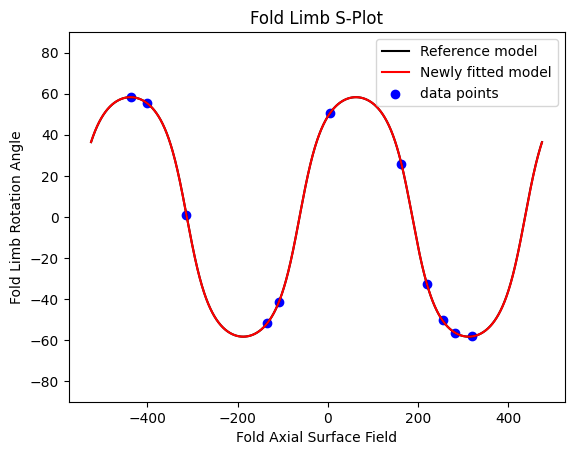

In [27]:
plt.ylim(-90, 90)
plt.xlabel('Fold Axial Surface Field')
plt.ylabel('Fold Limb Rotation Angle')
plt.title('Fold Limb S-Plot')
plt.plot(x, fold_limb_rotation, color='black', label='Reference model')
plt.plot(x, np.rad2deg(np.arctan(fourier_series(x, *opt.x))), color='red', label='Newly fitted model')
plt.scatter(fld, flr, color='blue', label='data points')
plt.legend()
plt.show()